In [21]:
# libraries
import numpy as np 
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense

# Data

In [22]:
data_folder = "cifar-10-python/cifar-10-batches-py"

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_data():
    data = []
    labels = []
    for i in range(1, 6):
        batch = unpickle(f"{data_folder}/data_batch_{i}")
        data.append(batch[b'data'])
        labels.append(batch[b'labels'])
    data = np.concatenate(data)
    labels = np.concatenate(labels)
    return data, labels

def load_test_data():
    batch = unpickle(f"{data_folder}/test_batch")
    data = batch[b'data']
    labels = batch[b'labels']
    return data, labels

def load_label_names():
    meta = unpickle(f"{data_folder}/batches.meta")
    return meta[b'label_names']

def visualize_image(image):
    image = image.reshape(3, 32, 32).transpose(1, 2, 0)
    plt.imshow(image)
    plt.show()


data, labels = load_data()
test_data, test_labels = load_test_data()
label_names = load_label_names()

print(data.shape)
print(labels.shape)
print(test_data.shape)
print(test_labels.__len__())
print(label_names)

(50000, 3072)
(50000,)
(10000, 3072)
10000
[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


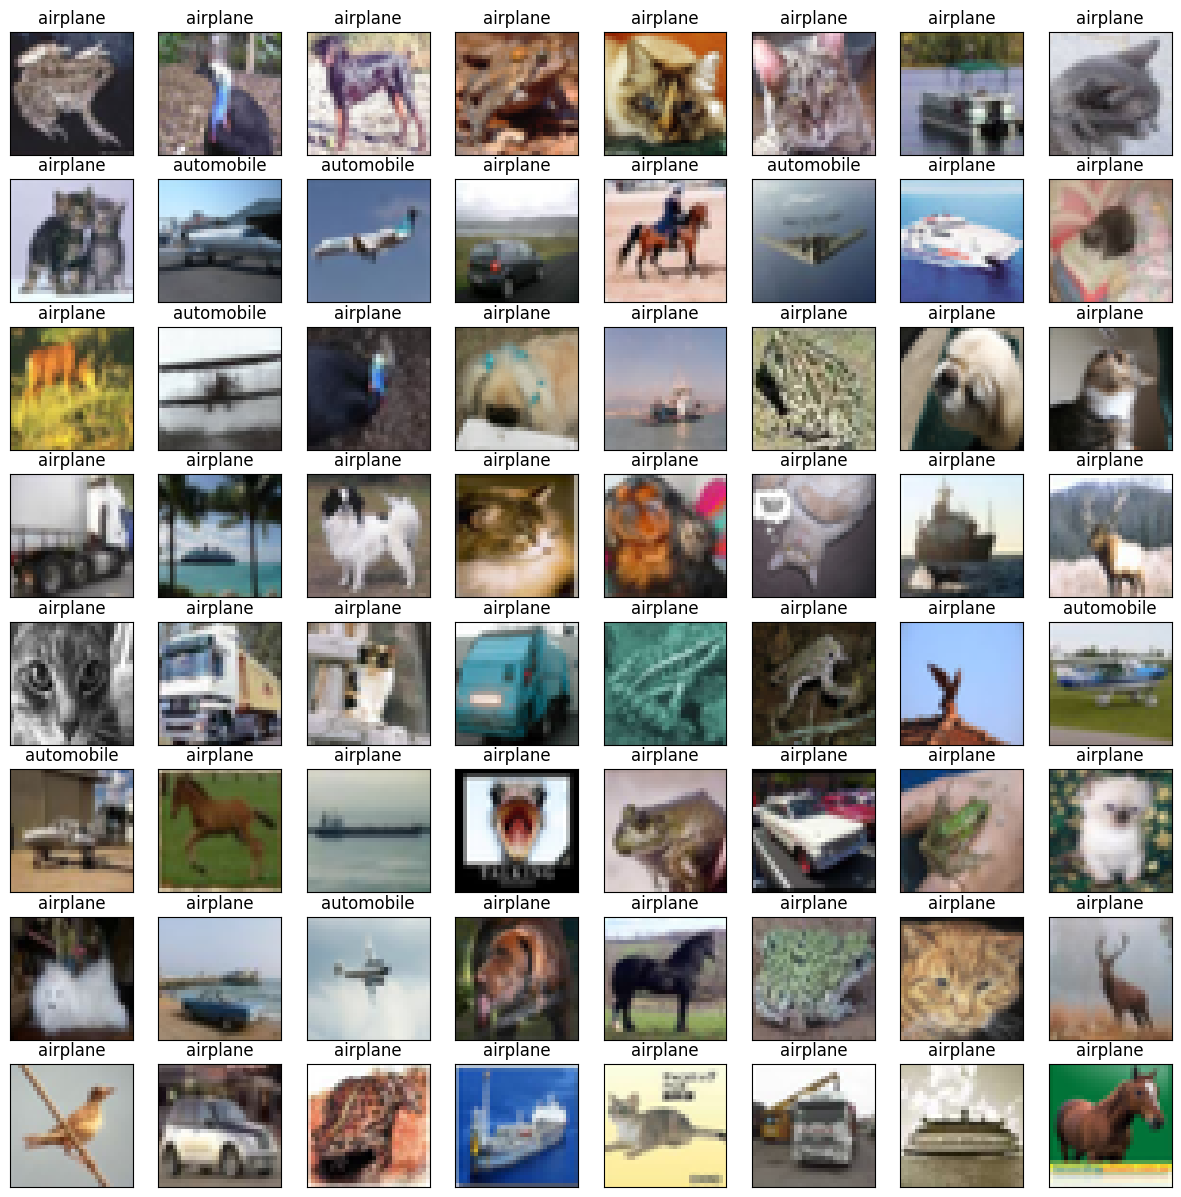

In [23]:
# reshape data

data = data.reshape(data.shape[0], 3, 32, 32).transpose(0, 2, 3, 1)
test_data = test_data.reshape(test_data.shape[0], 3, 32, 32).transpose(0, 2, 3, 1)

# split data into train and validation
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# normalize data
train_data = train_data / 255.0
val_data = val_data / 255.0
test_data = test_data / 255.0

# one hot encoding labels
train_labels = to_categorical(train_labels, num_classes=10)
val_labels = to_categorical(val_labels, num_classes=10)
test_labels = to_categorical(test_labels, num_classes=10)

# %%
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_labels = train_labels.astype(int)

plt.figure(figsize=(15,15))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_data[i])
    plt.title(class_names[train_labels[i][0]], fontsize=12)
plt.show()

# Model

In [24]:
model = Sequential([
    # First convolutional layer
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=train_data.shape[1:]),
    BatchNormalization(),
    
    # Second convolutional layer
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    
    # First max pooling and dropout
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(rate=0.2),
    
    # Third and fourth convolutional layers
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    
    # Second max pooling and increased dropout
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(rate=0.3),
    
    # Fifth and sixth convolutional layers
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    
    # Third max pooling and increased dropout
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(rate=0.4),

    # Flatten the tensor output
    Flatten(),
    
    # Output layer with softmax activation
    Dense(10, activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# %%
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 309,290 (1.18 MB)

 Trainable params: 308,394 (1.18 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.3474 - loss: 2.4029 - val_accuracy: 0.1893 - val_loss: 3.1094
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5594 - loss: 1.3666 - val_accuracy: 0.6058 - val_loss: 1.1649
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6371 - loss: 1.1197 - val_accuracy: 0.6527 - val_loss: 1.0593
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6851 - loss: 0.9614 - val_accuracy: 0.7065 - val_loss: 0.8537
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7173 - loss: 0.8296 - val_accuracy: 0.7324 - val_loss: 0.7941
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7482 - loss: 0.7432 - val_accuracy: 0.7604 - val_loss: 0.6981
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7663 - loss: 0.6805 - val_accuracy: 0.7827 - val_loss: 0.6365
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7852 - loss: 0.6101 - val_accuracy: 

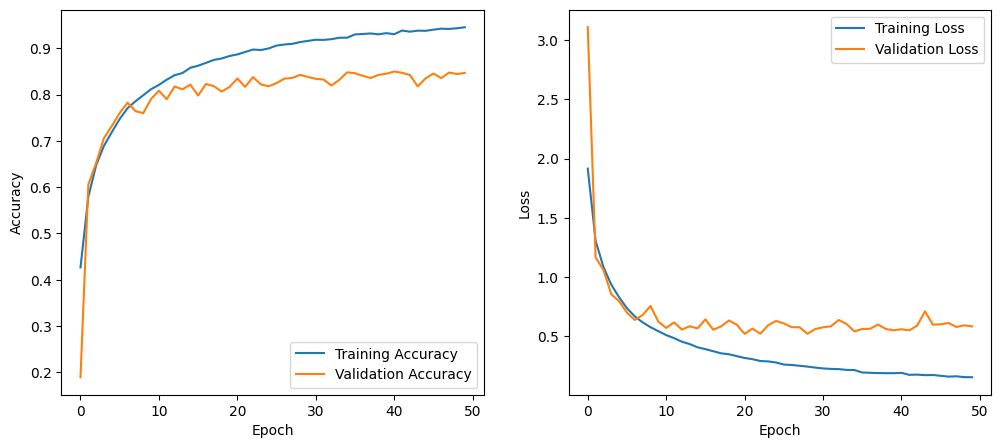

In [25]:
# %%
# Train the model
history = model.fit(train_data, train_labels, epochs=50, batch_size=128, validation_data=(val_data, val_labels))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_data, test_labels)
print('Test accuracy:', test_acc)

# %%
# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()  

In [26]:
# Check the model layer structure
for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.name}, {layer.__class__.__name__}")


Layer 0: conv2d_12, Conv2D
Layer 1: batch_normalization_12, BatchNormalization
Layer 2: conv2d_13, Conv2D
Layer 3: batch_normalization_13, BatchNormalization
Layer 4: max_pooling2d_6, MaxPooling2D
Layer 5: dropout_6, Dropout
Layer 6: conv2d_14, Conv2D
Layer 7: batch_normalization_14, BatchNormalization
Layer 8: conv2d_15, Conv2D
Layer 9: batch_normalization_15, BatchNormalization
Layer 10: max_pooling2d_7, MaxPooling2D
Layer 11: dropout_7, Dropout
Layer 12: conv2d_16, Conv2D
Layer 13: batch_normalization_16, BatchNormalization
Layer 14: conv2d_17, Conv2D
Layer 15: batch_normalization_17, BatchNormalization
Layer 16: max_pooling2d_8, MaxPooling2D
Layer 17: dropout_8, Dropout
Layer 18: flatten_2, Flatten
Layer 19: dense_2, Dense


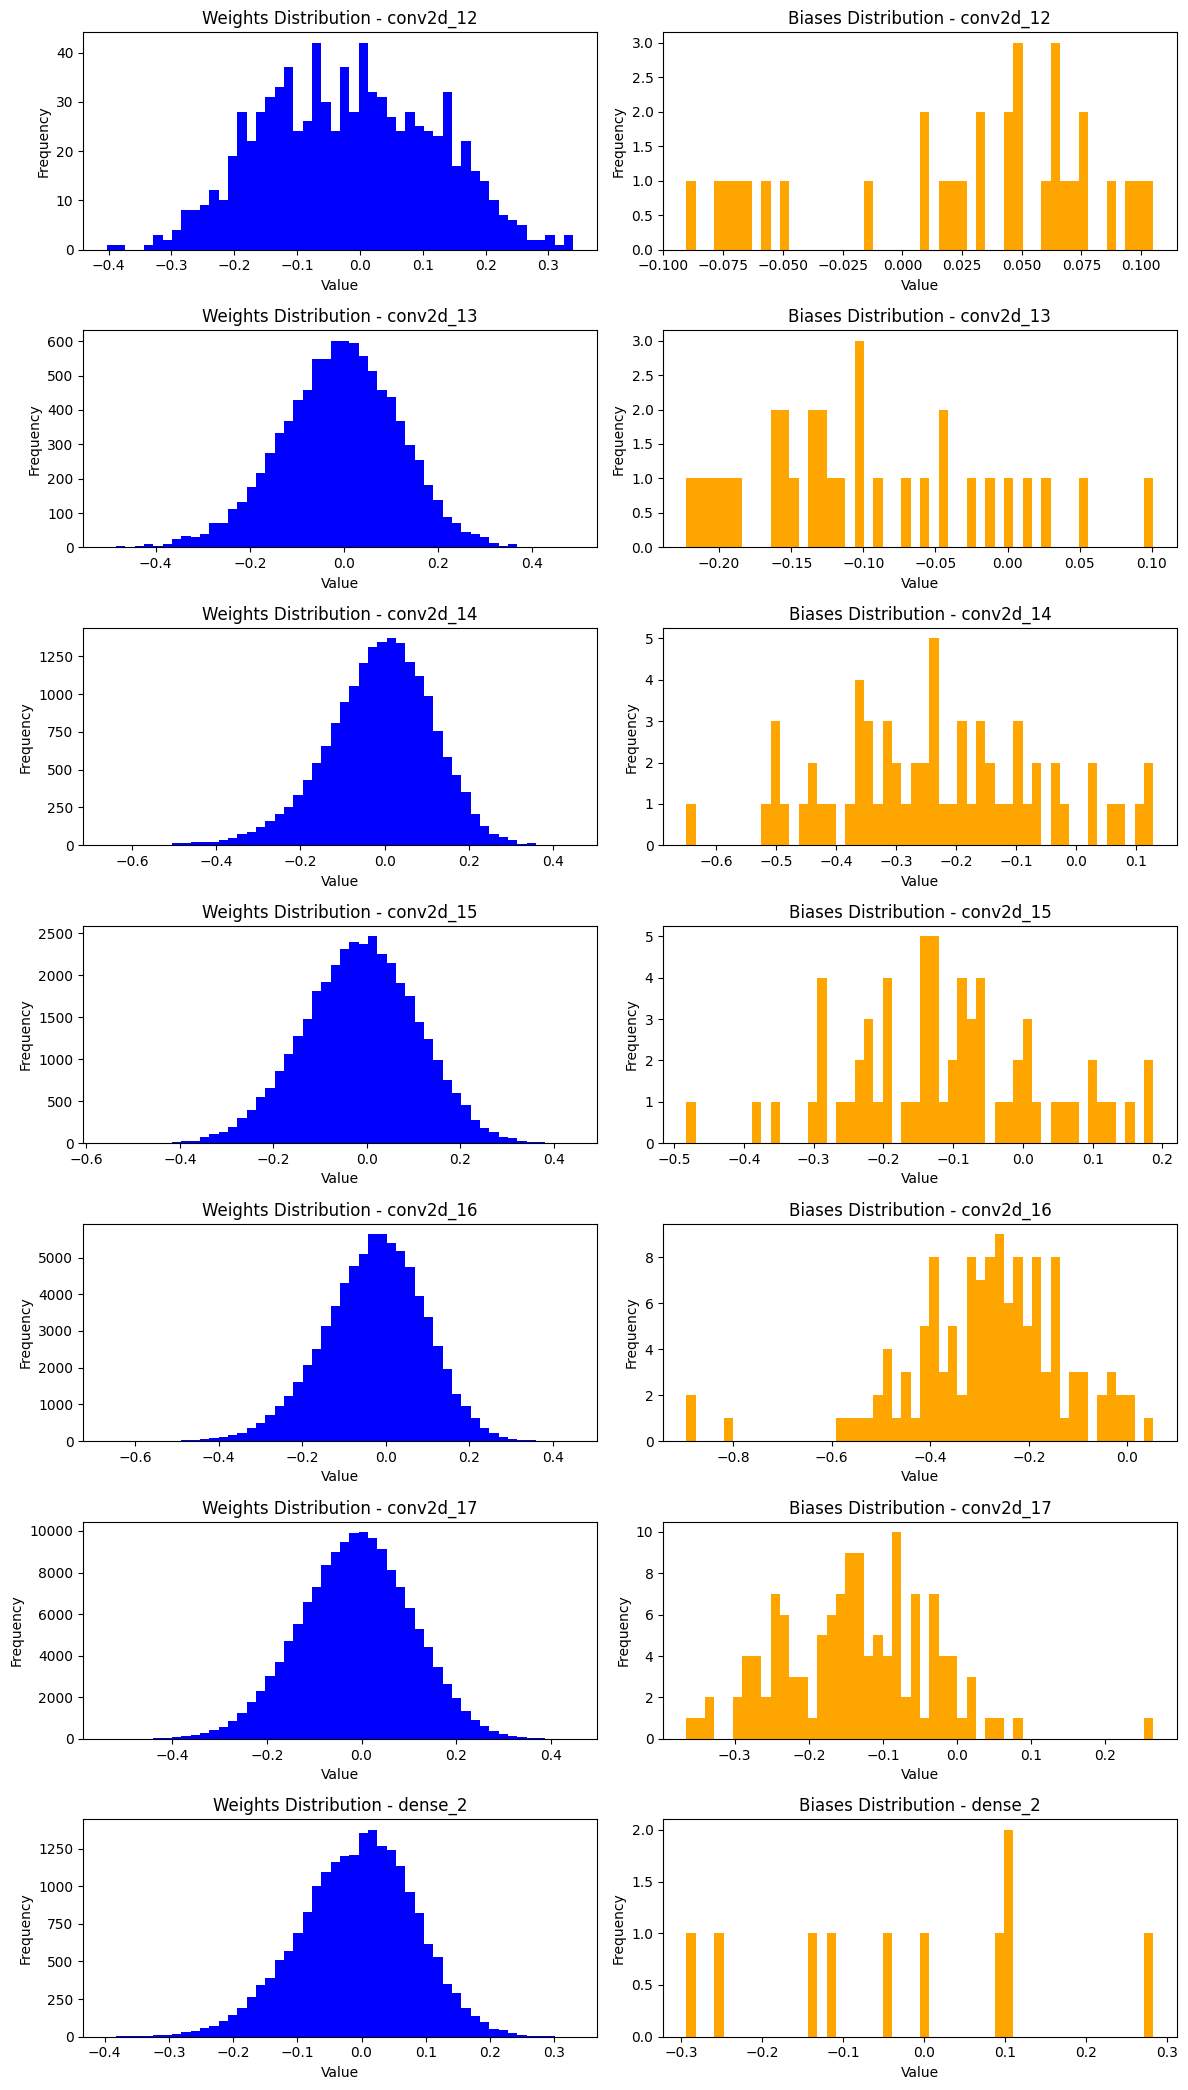

In [27]:
conv_and_dense_layers = [layer for layer in model.layers if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense))]

# Define the number of subplots (2 for each layer: weights and biases)
num_layers = len(conv_and_dense_layers)
fig, axes = plt.subplots(num_layers, 2, figsize=(12, 3 * num_layers))

# Loop through each layer and plot weights and biases
for i, layer in enumerate(conv_and_dense_layers):
    weights, biases = layer.get_weights()  # Extract weights and biases
    
    # Plot weights distribution
    axes[i, 0].hist(weights.flatten(), bins=50, color='blue')
    axes[i, 0].set_title(f'Weights Distribution - {layer.name}')
    axes[i, 0].set_xlabel('Value')
    axes[i, 0].set_ylabel('Frequency')
    
    # Plot biases distribution
    axes[i, 1].hist(biases.flatten(), bins=50, color='orange')
    axes[i, 1].set_title(f'Biases Distribution - {layer.name}')
    axes[i, 1].set_xlabel('Value')
    axes[i, 1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[[850   9  27  15   9   2   7   4  50  27]
 [ 13 909   3   2   2   1   6   0  15  49]
 [ 37   2 762  32  47  36  64   9   8   3]
 [ 16   3  32 659  43 128  83  17   9  10]
 [  9   2  32  29 851  18  40  14   3   2]
 [  9   2  24  94  40 783  20  22   2   4]
 [  3   0  11  24  11   4 941   1   2   3]
 [ 11   0  14  30  31  24   8 867   3  12]
 [ 32  12   3   4   3   1   4   0 925  16]
 [ 11  31   2   3   0   2   7   4  14 926]]


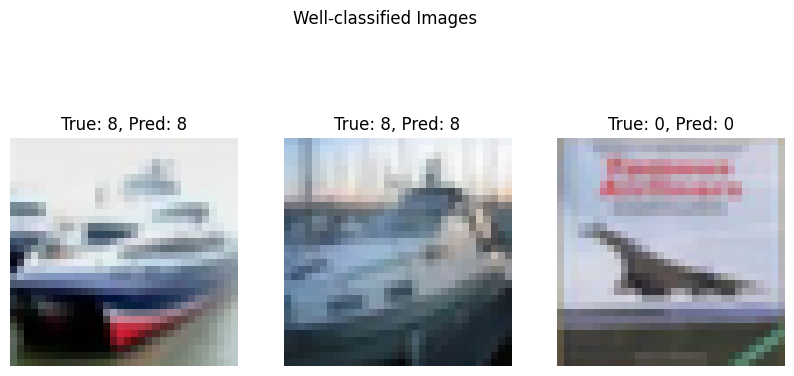

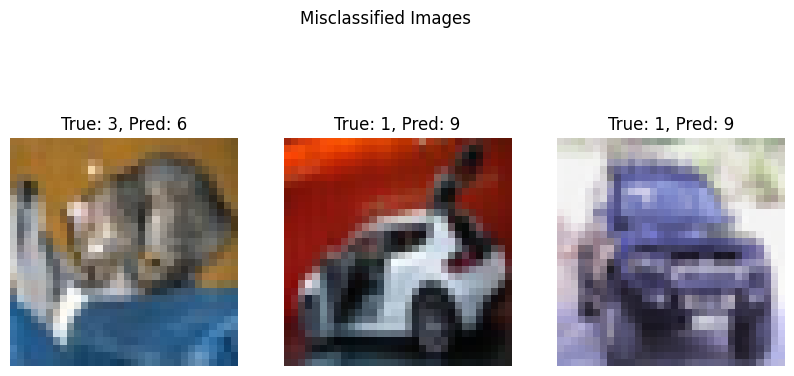

In [28]:
# %%
y_pred = model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(test_labels, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

# %%
correct_indices = np.where(y_pred == y_test)[0]
incorrect_indices = np.where(y_pred != y_test)[0]

plt.figure(figsize=(10, 5))
for i, idx in enumerate(correct_indices[:3]):
    plt.subplot(1, 3, i+1)
    plt.imshow(test_data[idx], cmap='gray')
    plt.title(f"True: {y_test[idx]}, Pred: {y_pred[idx]}")
    plt.axis('off')
plt.suptitle('Well-classified Images')
plt.show()

plt.figure(figsize=(10, 5))
for i, idx in enumerate(incorrect_indices[:3]):
    plt.subplot(1, 3, i+1)
    plt.imshow(test_data[idx], cmap='gray')
    plt.title(f"True: {y_test[idx]}, Pred: {y_pred[idx]}")
    plt.axis('off')
plt.suptitle('Misclassified Images')
plt.show()

# Visualize feature Maps

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


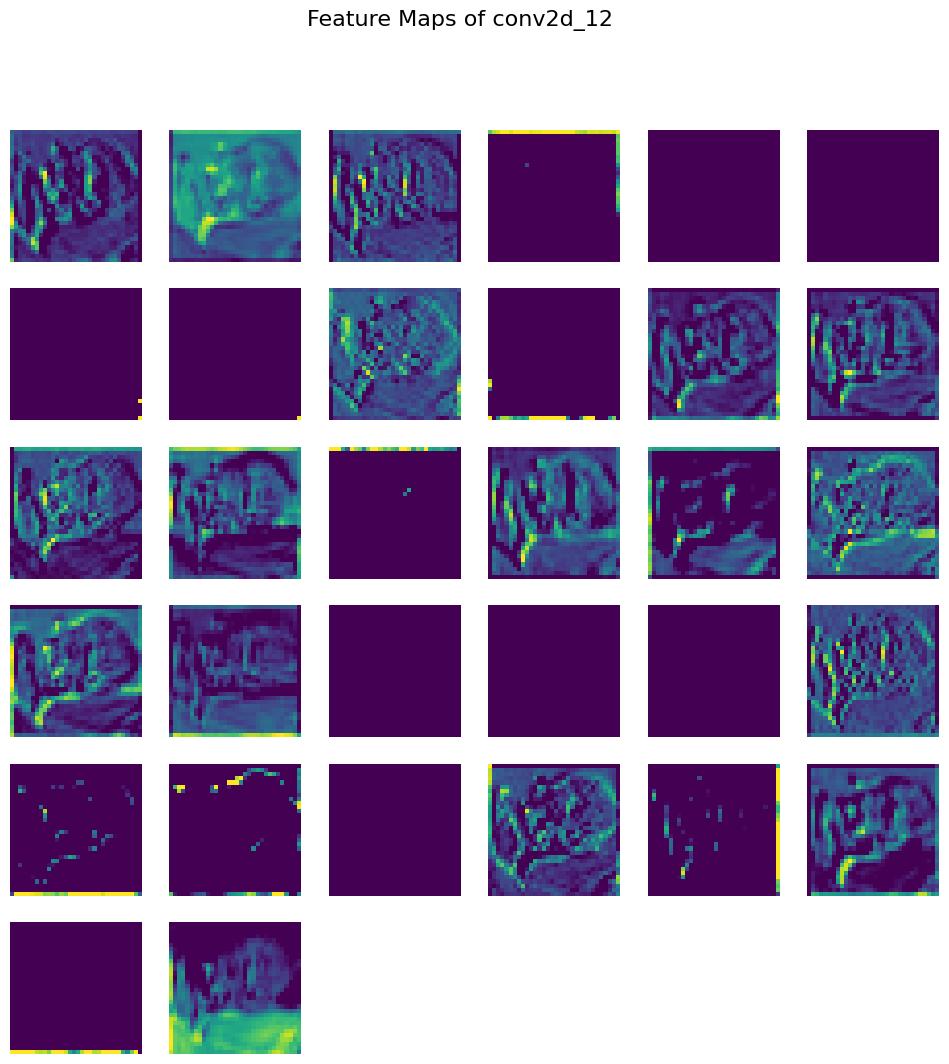

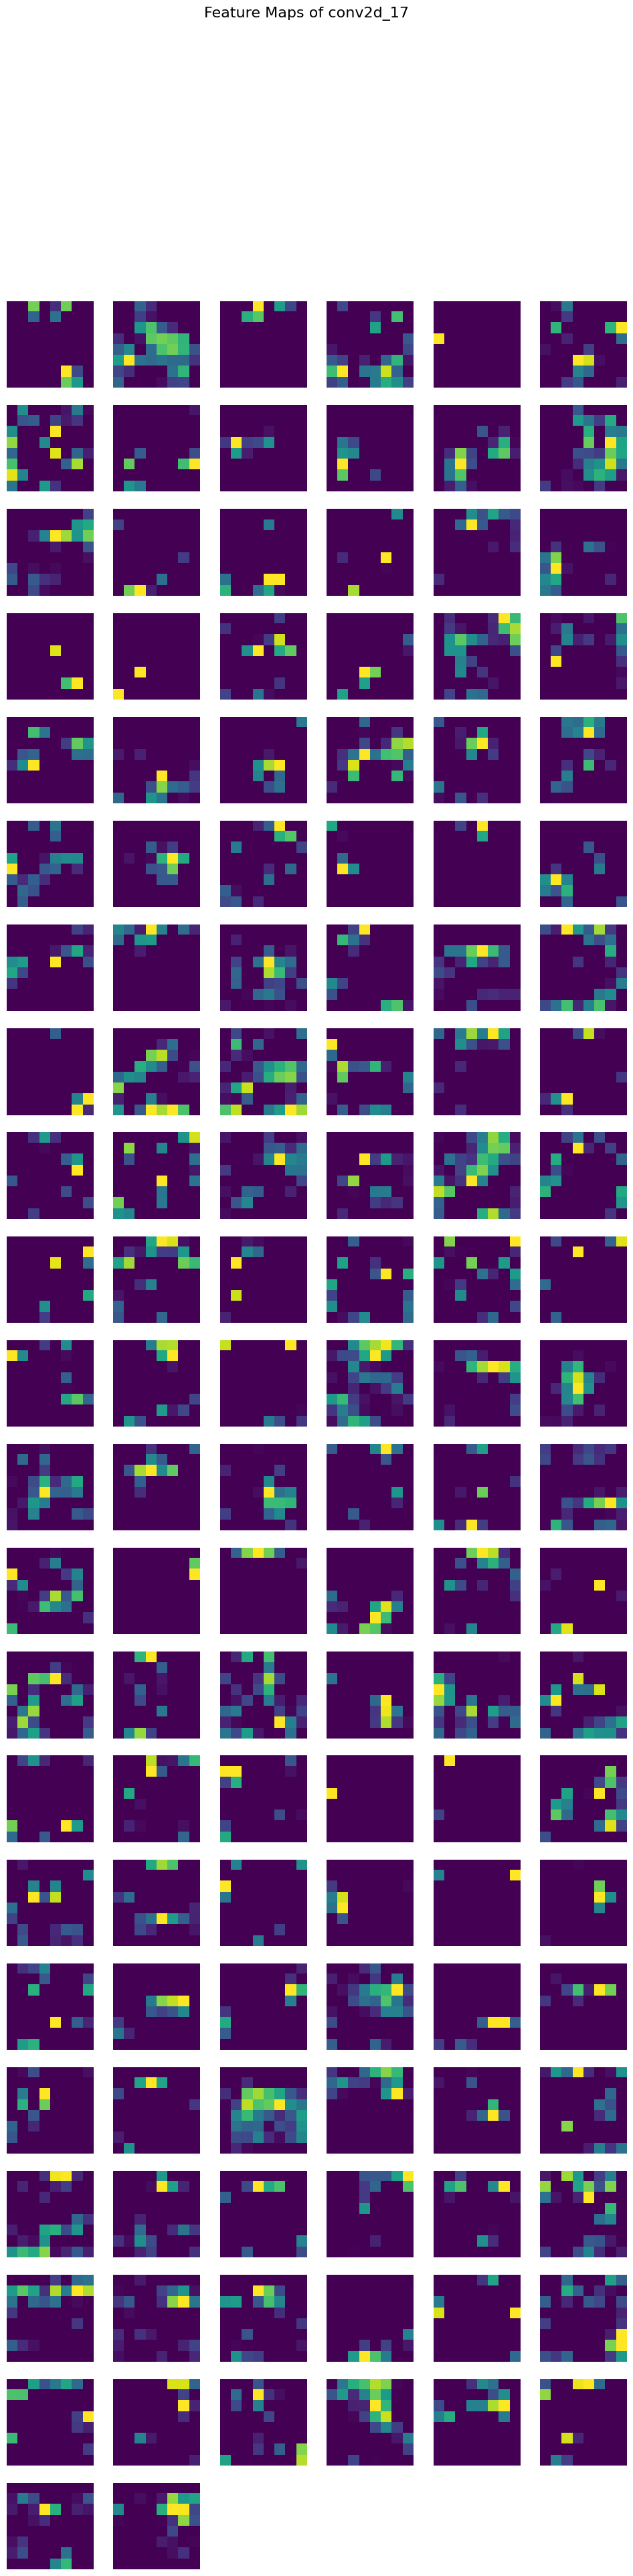

In [63]:
layer_names = ['conv2d_12', 'conv2d_17']
conv_layer_outputs = [model.get_layer(name).output for name in layer_names]
activation_model = Model(inputs=model.inputs, outputs=conv_layer_outputs)

img = test_data[0]
img = img[np.newaxis, ...]

feature_maps = activation_model.predict(img)
for layer_name, feature_map in zip(layer_names, feature_maps):
    n_features = feature_map.shape[-1]
    size = feature_map.shape[1]
    cols = 6
    rows = (n_features + cols - 1) // cols
    plt.figure(figsize=(cols * 2, rows * 2))
    plt.suptitle(f"Feature Maps of {layer_name}", fontsize=16)

    for i in range(n_features):
        ax = plt.subplot(rows, cols, i + 1)
        x = feature_map[0, :, :, i]
        x -= x.mean()
        x /= (x.std() + 1e-5)
        x = np.clip(x * 0.1 + 0.5, 0, 1)
        
        # Display the feature map
        ax.imshow(x, cmap='viridis')
        ax.axis('off')

    plt.show()